# Finding the Best Hotel in Paris
### Applied Data Science Capstone Project (IBM Data Science)
##### **Author:** Tristan S. Renaud  
##### **Date of code execution:** September 29th, 2020

## Table of contents
1. [**Libraries & Dependencies**](#LibrariesAndDependencies)
2. [**Introduction (Business Problem)**](#Introduction)
3. [**Data Sources**](#DataSources)
4. [**Data Collection & Cleaning**](#DataCollection)  
    4.1 [Latitude and longitude of Paris](#LatLon)  
    4.2 [Hotel data](#HotelData)  
    4.3 [Hotel details using Foursquare "venue details" call](#HotelDetails)  
    4.4 [First data clean](#DataClean)  
    4.5 [Get Yelp IDs through Yelp Fusion "business match" endpoint](#YelpID)  
    4.6 [Acquire additional information from Yelp Fusion "business details" endpoint](#YelpDetails)  
    4.7 [Second data clean](#DataClean2)  
    4.8 [Venues within "walking distance" to each hotel](#NearbyVenue)  
5. [**Data Methodology**](#Methodology)  
    5.1 [Prepare for machine learning](#MachineLearning)  
    5.2 [Determine ideal cluster count](#IdealCluster)  
    5.3 [Apply k-means clustering](#KMeans)  
    5.4 [Cluster selection](#ClusterSelection)  
    5.5 [Ranking hotels](#Ranking)  
6. [**Results**](#Results)  

# 1. Libraries & Dependencies <a name="LibrariesAndDependencies"></a>

In [1]:
import pandas as pd # Provides helpful data structures called "datafames"
import numpy as np # Handles data in a vectorized manner
import json # Handle JSON files
import requests # Handles API requests

# Provides geographical coordinates for addresses
from geopy.geocoders import Nominatim 

# Tranform JSON file into a pandas dataframe
from pandas import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering stage
from sklearn.cluster import KMeans

# Normalize data for k-means
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

# Import elbow method visualizer to pick ideal cluster count
from yellowbrick.cluster import KElbowVisualizer

# Map rendering
import folium

# Math
import math

D:\Programs\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Displays all rows and columns of a datafame. Helpful when exploring data, but makes notebook lengthier.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 2. Introduction (Business Problem) <a name="Introduction"></a>

I would like to to take a trip to Paris (France), which  means I need to find a hotel! I would like to find a hotel that is:
1. Within my budget.
1. Walking distance to the types of places I'd like to visit. Examples include shopping, parks, types of eating, and live entertainment.
1. Well rated

We will generalize this problem to apply to anyone that would like to visit Paris and would like to find a hotel within proximity to certain places.

**In this project, we will use data science methods to identify the best hotels that meet our constraints.**

## 3. Data Sources <a name="DataSources"></a>

Based on our problem, we need the following information to make a decision:  

1. **Geographical coordinates of Paris, France.**
1. **Paris hotel data** (Name, Location, Rating(s), Pricing, etc.)
1. **Venues within "walking distance" to each hotel.**

We will use the following data sources to aquire the information above:  
* **Nominatum (GeoPy)** - We will use this to get the latitude and longitude values of Paris.
* **Foursquare API** - We will use this to get hotel data (except pricing) and venues in proximity to each hotel.
* **Yelp Fusion API** - We will use this to get hotel pricing and rating (Fourquare does not provide hotel pricing info)

## 4. Data Collection & Cleaning <a name="DataCollection"></a>

### 4.1 Latitude and longitude of Paris <a name="LatLon"></a>

In [3]:
# Retrieve Paris latitude and longitude
address = 'Paris, France'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Paris are 48.8566969, 2.3514616.


In [4]:
# Initialize map
paris_map = folium.Map(location=[48.8566969, 2.3514616], zoom_start=13,tiles='CartoDB positron')

# Show map
paris_map

### 4.2 Hotel Data <a name="HotelData"></a>

This section we will use the Foursqure Places API and Yelp Fusion API to acquire the hotel data needed for this project. This falls into three steps:
1. Get list of hotels using Foursquare 'explore' endpoint.
1. Get additional hotel details using Foursquare 'venue details' endpoint.
1. Get pricing info and other details from Yelp Fusion 'Business Match' endpoint.



In [5]:
# Foursquare credentials
CLIENT_ID = # Removed
CLIENT_SECRET = # Removed
VERSION = '20200330' # Foursquare API version

# Foursquare parameters
NEAR = 'Paris, France' # Foursquare creates a geocoded object (rectangular box) for Paris
CATEGORYID = '4bf58dd8d48988d1fa931735' # Restricts results to only hotels based on Foursquare's venue category hierarchy
OFFSET = 0 # Indicates which result to start with
LIMIT = 50 # 50 is the maximum number results returned per call

In [6]:
# We will use the "Get Venue Recommendations" endpoint to acquire a list of hotels in Paris
url = 'https://api.foursquare.com/v2/venues/explore'



# Prepare parameters
params = dict(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    v=VERSION,
    near=NEAR,
    categoryId=CATEGORYID,
    offset = OFFSET,
    limit = LIMIT,
    time='any',
    day='any')
 
# Pull response in json format and load it as a Python dictionary
initial_resp = requests.get(url=url, params=params)
initial_data = json.loads(initial_resp.text)

# Count how many hotels were returned and calculate number of pages of results
results_count = initial_data['response']['totalResults']
results_pages = math.ceil((results_count/LIMIT))

print(f'Foursquare found {results_count} hotels in Paris.')

Foursquare found 433 hotels in Paris.


In [7]:
# Example of what foursquare returns for each result in the venue explore call
initial_data['response']['groups'][0]['items'][0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4adcda00f964a520ba3021e3',
  'name': 'Hôtel Four Seasons George V',
  'location': {'address': '31 avenue George V',
   'lat': 48.868849,
   'lng': 2.300683,
   'labeledLatLngs': [{'label': 'display', 'lat': 48.868849, 'lng': 2.300683}],
   'postalCode': '75008',
   'cc': 'FR',
   'city': 'Paris',
   'state': 'Île-de-France',
   'country': 'France',
   'formattedAddress': ['31 avenue George V', '75008 Paris', 'France']},
  'categories': [{'id': '4bf58dd8d48988d1fa931735',
    'name': 'Hotel',
    'pluralName': 'Hotels',
    'shortName': 'Hotel',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-0-4adcda00f964a520ba3021e3-0'}

Lets pull this list of hotels. We will do this using the explore call and passing the category ID for hotels.

In [8]:
# Initialize url
url = 'https://api.foursquare.com/v2/venues/explore'

# Initialize list
hotels_list=[]

# Pull hotel data through the results
for page in list(range(0,results_pages)):
    params_hotel = dict(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        v=VERSION,
        near=NEAR,
        categoryId=CATEGORYID,
        offset = page * LIMIT,
        limit = LIMIT,
        time='any',
        day='any',
        sortByDistance = 1)
    try: hotel_search = requests.get(url=url, params=params_hotel).json()['response']['groups'][0]['items']
    except: hotel_search = requests.get(url=url, params=params_hotel).json()['response']['groups'][0]['items']
    
    # Add relevant data to list
    hotels_list.append([(
        vs['venue']['id'], # Foursquare ID (we'll use this to get rating)
        vs['venue']['name'], # name
        vs['venue']['location']['lat'], # latitude
        vs['venue']['location']['lng']) for vs in hotel_search]) # longitude
    
    # Make sure we pull the correct number of results on each page
    print("page",page+1,"with",len(hotel_search),"results")

page 1 with 50 results
page 2 with 50 results
page 3 with 50 results
page 4 with 50 results
page 5 with 50 results
page 6 with 50 results
page 7 with 50 results
page 8 with 50 results
page 9 with 33 results


We will place relevant data into a dataframe.

In [9]:
#Let's put this data into a Pandas dataframe
hotels_df = pd.DataFrame([item for hotel_list in hotels_list for item in hotel_list]) #throw hotel data into datafame
hotels_df.columns = ['id',
                    'name',
                    'latitude',
                    'longitude']
print(f'Query pulled {hotels_df.shape[0]} hotels.')
hotels_df.head()

Query pulled 433 hotels.


,id,name,latitude,longitude
0,590c698f356b492c77bba4fe,Hotel Dieu,48.854243,2.348619
1,4adcda02f964a520953121e3,Hôtel Le Notre-Dame,48.853040,2.346504
2,4adcda00f964a520f43021e3,Hôtel Meliá Colbert,48.851647,2.348661
3,4adcd9fff964a520af3021e3,Hôtel Les Rives de Notre-Dame,48.853252,2.345773
4,4cf12e897bf3b60c5d115e7f,Hôtel Henri IV Rive Gauche,48.851885,2.346291


We now have an id, name, latitude and longitude for each hotel.

Before proceeding, let's drop any potential duplicates.

In [10]:
# Drop duplicates
print(f'{hotels_df.shape[0]} hotels *before* deduping.')
hotels_df = hotels_df.drop_duplicates(subset='id')
print(f'{hotels_df.shape[0]} hotels *after* deduping.')

433 hotels *before* deduping.
433 hotels *after* deduping.


Let's visualize our hotels on a map.

In [11]:
# Plot the hotels on a map
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12,tiles='CartoDB positron')

# Add markers to map
for lat, lng, hotel in zip(hotels_df['latitude'], hotels_df['longitude'], hotels_df['name']):
    label = hotel
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

### 4.3  Hotel details using Foursquare "venue details" call <a name="HotelDetails"></a>

Time to learn more about these hotels... Lets pull venue details.

In [12]:
# Set up 'Venue Details' url with a sample hotel
venue_detail_url = 'https://api.foursquare.com/v2/venues/'+ hotels_df.loc[1,'id'] 

# Prepare parameters
params = dict(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    v=VERSION)

# Let's pull and lad data into a json file
initial_resp = requests.get(url=venue_detail_url, params=params)
initial_data = json.loads(initial_resp.text)

Closer look at the details...

In [13]:
initial_data['response']['venue']

{'id': '4adcda02f964a520953121e3',
 'name': 'Hôtel Le Notre-Dame',
 'contact': {'phone': '+33143542043', 'formattedPhone': '+33 1 43 54 20 43'},
 'location': {'address': '1 quai Saint-Michel',
  'lat': 48.85303971813958,
  'lng': 2.346503734588623,
  'labeledLatLngs': [{'label': 'display',
    'lat': 48.85303971813958,
    'lng': 2.346503734588623}],
  'postalCode': '75005',
  'cc': 'FR',
  'city': 'Paris',
  'state': 'Île-de-France',
  'country': 'France',
  'formattedAddress': ['1 quai Saint-Michel', '75005 Paris', 'France']},
 'canonicalUrl': 'https://foursquare.com/v/h%C3%B4tel-le-notredame/4adcda02f964a520953121e3',
 'categories': [{'id': '4bf58dd8d48988d1fa931735',
   'name': 'Hotel',
   'pluralName': 'Hotels',
   'shortName': 'Hotel',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
    'suffix': '.png'},
   'primary': True}],
 'verified': True,
 'stats': {'tipCount': 11},
 'url': 'http://www.hotelnotredameparis.com',
 'likes': {'count': 30,
  'group

By converting this data to a pandas dataframe, we can easily query the fields returned.

In [14]:
# Place into dataframe
hotel_specifics_test = json_normalize(initial_data['response']['venue'])

# Let's see what columns we're working with
hotel_specifics_test.columns

Index(['id', 'name', 'canonicalUrl', 'categories', 'verified', 'url',
       'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals',
       'allowMenuUrlEdit', 'description', 'createdAt', 'shortUrl', 'timeZone',
       'seasonalHours', 'contact.phone', 'contact.formattedPhone',
       'location.address', 'location.lat', 'location.lng',
       'location.labeledLatLngs', 'location.postalCode', 'location.cc',
       'location.city', 'location.state', 'location.country',
       'location.formattedAddress', 'stats.tipCount', 'likes.count',
       'likes.groups', 'likes.summary', 'beenHere.count',
       'beenHere.unconfirmedCount', 'beenHere.marked',
       'beenHere.lastCheckinExpiredAt', 'specials.count', 'specials.items',
       'photos.count', 'photos.groups', 'venuePage.id', 'reasons.count',
       'reasons.items', 'page.user.id', 'page.user.firstName',
       'page.user.photo.prefix', 'page.user.photo.suffix', 'page.user.type',
       'page.user.venue.id', 'page.user.tips.count', '

Let's add the following details from the list above:
  
1. **url** - website so we can learn more about recommended hotels  
1. **rating** - We'll prefer locations with better ratings (what if location has no rating?)  
1. **ratingSignals** - number of ratings the venue received (statistical assessment)  
1. **contact.formattedPhone** - Phone number
1. **location.[formattedAddress, address, city, state, postalCode, cc, country]** - Hotel address

In [15]:
# Lay out columns we want
filtered_columns = ['rating','ratingSignals','location.address','location.city','location.state','location.cc','location.formattedAddress','contact.formattedPhone','url']

Lets pull these columns for each hotel.

In [16]:
# Initialize url
base_url = 'https://api.foursquare.com/v2/venues/'

params_details = dict(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    v=VERSION
    )

# Set formatted address column to object type
hotels_df['location.formattedAddress'] = np.nan
hotels_df['location.formattedAddress'] = hotels_df['location.formattedAddress'].astype(object)

# Pull hotel data through each page of results
for row in list(hotels_df.index):
    url = base_url + hotels_df.loc[row,'id'] #build url
    
    try:
        venue_response = requests.get(url=url, params=params_details)
        venue_json = json.loads(venue_response.text)
        venue_normalize = json_normalize(venue_json['response']['venue'])
    except:
        venue_response = requests.get(url=url, params=params_details)
        venue_json = json.loads(venue_response.text)
        venue_normalize = json_normalize(venue_json['response']['venue'])        

    # Populate our hotel dataframe with venue details
    for column in filtered_columns:
        try: 
            hotels_df.at[row,column] = venue_normalize.loc[0,column]
        except:
            print(f'Row {row} {column} not in venue details')

Row 0 rating not in venue details
Row 0 ratingSignals not in venue details
Row 0 location.address not in venue details
Row 0 contact.formattedPhone not in venue details
Row 0 url not in venue details
Row 9 contact.formattedPhone not in venue details
Row 9 url not in venue details
Row 10 contact.formattedPhone not in venue details
Row 10 url not in venue details
Row 15 url not in venue details
Row 16 contact.formattedPhone not in venue details
Row 16 url not in venue details
Row 20 rating not in venue details
Row 20 ratingSignals not in venue details
Row 22 url not in venue details
Row 29 url not in venue details
Row 38 rating not in venue details
Row 38 ratingSignals not in venue details
Row 41 contact.formattedPhone not in venue details
Row 41 url not in venue details
Row 48 rating not in venue details
Row 48 ratingSignals not in venue details
Row 49 rating not in venue details
Row 49 ratingSignals not in venue details
Row 51 contact.formattedPhone not in venue details
Row 52 rating n

In [17]:
# Data Preview
print(f'Dataset has {hotels_df.shape[0]} rows and {hotels_df.shape[1]} columns.')
hotels_df.head()

Dataset has 433 rows and 13 columns.


,id,name,latitude,longitude,location.formattedAddress,location.city,location.state,location.cc,rating,ratingSignals,location.address,contact.formattedPhone,url
0,590c698f356b492c77bba4fe,Hotel Dieu,48.854243,2.348619,"[75004 Paris, France]",Paris,Île-de-France,FR,NaN,NaN,NaN,NaN,NaN
1,4adcda02f964a520953121e3,Hôtel Le Notre-Dame,48.853040,2.346504,"[1 quai Saint-Michel, 75005 Paris, France]",Paris,Île-de-France,FR,6.9,45.0,1 quai Saint-Michel,+33 1 43 54 20 43,http://www.hotelnotredameparis.com
2,4adcda00f964a520f43021e3,Hôtel Meliá Colbert,48.851647,2.348661,"[7 rue de l'Hôtel Colbert, 75005 Paris, France]",Paris,Île-de-France,FR,7.6,22.0,7 rue de l'Hôtel Colbert,+33 800 91 91 30,http://www.melia.com/en/hotels/france/paris/me...
3,4adcd9fff964a520af3021e3,Hôtel Les Rives de Notre-Dame,48.853252,2.345773,"[15 quai St Michel, 75005 Paris, France]",Paris,Île-de-France,FR,7.3,8.0,15 quai St Michel,+33 1 43 54 81 16,http://www.rivesdenotredame.com
4,4cf12e897bf3b60c5d115e7f,Hôtel Henri IV Rive Gauche,48.851885,2.346291,"[11 rue Saint-Jacques (Rue Galande), 75005 Par...",Paris,Île-de-France,FR,6.6,16.0,11 rue Saint-Jacques,+33 1 46 33 20 20,https://henri-paris-hotel.com/fr/


### 4.4 First data clean <a name="DataClean"></a>

Performing a data clean before matching up date to yelp will reduce the number of API calls placed.

In [18]:
# Clean out hotels not in Paris (location.city)
hotels_df = hotels_df[hotels_df['location.city'] == 'Paris'].reset_index(drop=True)

# Trim column names
hotels_df.columns = [col.split(".")[-1] for col in hotels_df.columns]

print(f'Dataset has {hotels_df.shape[0]} rows and {hotels_df.shape[1]} columns.')
hotels_df.head()

Dataset has 380 rows and 13 columns.


,id,name,latitude,longitude,formattedAddress,city,state,cc,rating,ratingSignals,address,formattedPhone,url
0,590c698f356b492c77bba4fe,Hotel Dieu,48.854243,2.348619,"[75004 Paris, France]",Paris,Île-de-France,FR,NaN,NaN,NaN,NaN,NaN
1,4adcda02f964a520953121e3,Hôtel Le Notre-Dame,48.853040,2.346504,"[1 quai Saint-Michel, 75005 Paris, France]",Paris,Île-de-France,FR,6.9,45.0,1 quai Saint-Michel,+33 1 43 54 20 43,http://www.hotelnotredameparis.com
2,4adcda00f964a520f43021e3,Hôtel Meliá Colbert,48.851647,2.348661,"[7 rue de l'Hôtel Colbert, 75005 Paris, France]",Paris,Île-de-France,FR,7.6,22.0,7 rue de l'Hôtel Colbert,+33 800 91 91 30,http://www.melia.com/en/hotels/france/paris/me...
3,4adcd9fff964a520af3021e3,Hôtel Les Rives de Notre-Dame,48.853252,2.345773,"[15 quai St Michel, 75005 Paris, France]",Paris,Île-de-France,FR,7.3,8.0,15 quai St Michel,+33 1 43 54 81 16,http://www.rivesdenotredame.com
4,4cf12e897bf3b60c5d115e7f,Hôtel Henri IV Rive Gauche,48.851885,2.346291,"[11 rue Saint-Jacques (Rue Galande), 75005 Par...",Paris,Île-de-France,FR,6.6,16.0,11 rue Saint-Jacques,+33 1 46 33 20 20,https://henri-paris-hotel.com/fr/


### 4.5 Get Yelp IDs through Yelp Fusion "business match" endpoint <a name="YelpID"></a>

Unfortunately, Foursquare does not provide pricing info for hotels.
The good news is Yelp does provide pricing info. While we are querying Yelp, we will look out for other columns that can improve our analysis.  

Let's start by finding our hotels on Yelp using the "business match" endpoint.

In [19]:
# Let's explore the Yelp business match endpoint
API_KEY = # Removed

# Initialize url
yelp_test_url = 'https://api.yelp.com/v3/businesses/matches'

# Initialize header
yelp_test_headers = dict(
    Authorization = 'Bearer ' + API_KEY
    )

# Initialize parameters
yelp_test_params =  dict(
    name = hotels_df.loc[1,'name'],
    address1 = hotels_df.loc[1,'address'],
    city = hotels_df.loc[1,'city'],
    state = 'IDF', #State code of Île-de-France
    country = hotels_df.loc[1,'cc'],
    latitude = hotels_df.loc[1,'latitude'],
    longitude = hotels_df.loc[1,'longitude'],
    limit = 1
    )

# GET request
yelp_resp = requests.get(url=yelp_test_url, headers=yelp_test_headers, params=yelp_test_params).json()

# Place relevant data into datafame
yelp_test_df = json_normalize(yelp_resp['businesses'][0])

yelp_test_df.head(1)

,id,alias,name,phone,display_phone,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address
0,2i5m01j1Sbq9SW8mxN3lVQ,hôtel-notre-dame-paris-4,Hôtel Notre-Dame,+33143542043,+33 1 43 54 20 43,48.853031,2.346574,1 quai Saint-Michel,,,Paris,75005,FR,75,"[1 quai Saint-Michel, 75005 Paris, France]"


Looks like we're in business!

Example:

In [20]:
yelp_resp

{'businesses': [{'id': '2i5m01j1Sbq9SW8mxN3lVQ',
   'alias': 'hôtel-notre-dame-paris-4',
   'name': 'Hôtel Notre-Dame',
   'coordinates': {'latitude': 48.853031, 'longitude': 2.346574},
   'location': {'address1': '1 quai Saint-Michel',
    'address2': '',
    'address3': '',
    'city': 'Paris',
    'zip_code': '75005',
    'country': 'FR',
    'state': '75',
    'display_address': ['1 quai Saint-Michel', '75005 Paris', 'France']},
   'phone': '+33143542043',
   'display_phone': '+33 1 43 54 20 43'}]}

Let us grab the 'id' and 'name' for each location.

In [21]:
# Initialize url
yelp_url = 'https://api.yelp.com/v3/businesses/matches'

# Initialize headers
yelp_headers = dict(
    Authorization = 'Bearer ' + API_KEY
    )

#Pull Yelp data for each row of hotels
for row in list(hotels_df.index):

    yelp_params =  dict(
    name = hotels_df.loc[row,'name'],
    address1 = hotels_df.loc[row,'address'],
    city = 'Paris',
    state = 'IDF', #State code of Île-de-France
    country = 'FR',   
    latitude = hotels_df.loc[row,'latitude'],
    longitude = hotels_df.loc[row,'longitude'],
    limit = 1
    )
    
    yelp_response = requests.get(url=yelp_url, headers=yelp_headers, params=yelp_params).json() #fetch venue details
    
    # Populate our hotel dataframe with venue details
    try: 
        hotels_df.loc[row,'yelp.id'] = yelp_response['businesses'][0]['id']
    except:
        print('Row',row,'id not in yelp details')
    
    try: 
        hotels_df.loc[row,'yelp.name'] = yelp_response['businesses'][0]['name']
    except:
        print('Row',row,'name not in yelp details')

Row 0 id not in yelp details
Row 0 name not in yelp details
Row 2 id not in yelp details
Row 2 name not in yelp details
Row 11 id not in yelp details
Row 11 name not in yelp details
Row 18 id not in yelp details
Row 18 name not in yelp details
Row 51 id not in yelp details
Row 51 name not in yelp details
Row 53 id not in yelp details
Row 53 name not in yelp details
Row 68 id not in yelp details
Row 68 name not in yelp details
Row 84 id not in yelp details
Row 84 name not in yelp details
Row 85 id not in yelp details
Row 85 name not in yelp details
Row 109 id not in yelp details
Row 109 name not in yelp details
Row 126 id not in yelp details
Row 126 name not in yelp details
Row 128 id not in yelp details
Row 128 name not in yelp details
Row 132 id not in yelp details
Row 132 name not in yelp details
Row 135 id not in yelp details
Row 135 name not in yelp details
Row 136 id not in yelp details
Row 136 name not in yelp details
Row 139 id not in yelp details
Row 139 name not in yelp detail

In [22]:
print(f'Dataset has {hotels_df.shape[0]} rows and {hotels_df.shape[1]} columns.')

Dataset has 380 rows and 15 columns.


In [23]:
# Drop hotels with no Yelp match
hotels_df = hotels_df.dropna(subset=['yelp.id'])
hotels_df = hotels_df.reset_index(drop=True)

print(f'After dropping rows with no yelp match, the dataset has {hotels_df.shape[0]} rows and {hotels_df.shape[1]} columns.')

After dropping rows with no yelp match, the dataset has 319 rows and 15 columns.


### 4.6 Acquire additional information from Yelp Fusion "business details" endpoint <a name="YelpDetails"></a>

Let's explore the Yelp "Businss Details" endpoint

In [24]:
# Initialize url...
yelpDetail_test_url = 'https://api.yelp.com/v3/businesses/' + hotels_df.loc[0,'yelp.id']

# GET request using headers from previous Yelp api request
yelpDetail_test_resp = requests.get(url=yelpDetail_test_url, headers=yelp_test_headers).json()

# Place data into datafame
yelpDetail_test_df = json_normalize(yelpDetail_test_resp)

yelpDetail_test_df

,id,alias,name,image_url,is_claimed,is_closed,url,phone,display_phone,review_count,categories,rating,photos,price,transactions,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,location.cross_streets,coordinates.latitude,coordinates.longitude
0,2i5m01j1Sbq9SW8mxN3lVQ,hôtel-notre-dame-paris-4,Hôtel Notre-Dame,https://s3-media4.fl.yelpcdn.com/bphoto/o-JIFx...,False,False,https://www.yelp.com/biz/h%C3%B4tel-notre-dame...,+33143542043,+33 1 43 54 20 43,14,"[{'alias': 'hotels', 'title': 'Hotels'}]",4.0,[https://s3-media4.fl.yelpcdn.com/bphoto/o-JIF...,€€,[],1 quai Saint-Michel,,,Paris,75005,FR,75,"[1 quai Saint-Michel, 75005 Paris, France]",,48.853031,2.346574


Let's grab price, rating, review_count and is_claimed

In [25]:
# Establish columns we would like to pull
filteredYelp_columns = ['price','rating','review_count','is_claimed']


# Pull yelp data for each row of hotels
for row in list(hotels_df.index):
    
    yelpDetail_url = 'https://api.yelp.com/v3/businesses/' + hotels_df.loc[row,'yelp.id']
    
    yelpDetail_response = requests.get(url=yelpDetail_url, headers=yelp_headers).json() #fetch venue details
    
    yelpDetail_df = json_normalize(yelpDetail_response)
    
    # Populate our hotel dataframe with venue details
    for column in filteredYelp_columns:
        try: 
            hotels_df.loc[row,'yelp.' + column] = yelpDetail_df.loc[0,column]
        except:
            print(f'Row {row} {column} not in yelp business details')

Row 14 price not in yelp business details
Row 21 price not in yelp business details
Row 31 price not in yelp business details
Row 46 price not in yelp business details
Row 66 price not in yelp business details
Row 67 price not in yelp business details
Row 75 price not in yelp business details
Row 81 price not in yelp business details
Row 84 price not in yelp business details
Row 104 price not in yelp business details
Row 106 price not in yelp business details
Row 111 price not in yelp business details
Row 117 price not in yelp business details
Row 137 price not in yelp business details
Row 141 price not in yelp business details
Row 148 price not in yelp business details
Row 156 price not in yelp business details
Row 163 price not in yelp business details
Row 176 price not in yelp business details
Row 184 price not in yelp business details
Row 186 price not in yelp business details
Row 192 price not in yelp business details
Row 198 price not in yelp business details
Row 200 price not in

In [26]:
# Drop columns missing price
df = hotels_df.dropna(subset = ['yelp.price'])

# Drop columns missing both foursquare and yelp rating
df = df.dropna(subset = ['rating','yelp.rating'])

df = df.reset_index(drop=True)
df.shape

(249, 19)

In [27]:
# Convert 'yelp.price' from a string of €'s to a number
df['yelp.price'] = df['yelp.price'].apply(len)
df['yelp.price'].unique()

array([2, 1, 3, 4], dtype=int64)

### 4.7 Second data clean <a name="DataClean2"></a>
Let's look at our data at a high level:

In [28]:
df.describe(include='all')

,id,name,latitude,longitude,formattedAddress,city,state,cc,rating,ratingSignals,address,formattedPhone,url,yelp.id,yelp.name,yelp.price,yelp.rating,yelp.review_count,yelp.is_claimed
count,249,249,249.000000,249.000000,249,249,249,249,249.000000,249.000000,249,220,210,249,249,249.000000,249.000000,249.000000,249
unique,249,249,NaN,NaN,246,1,2,1,NaN,NaN,246,219,204,246,246,NaN,NaN,NaN,2
top,4e344041c65bdb4c7a067479,Hôtel Particulier Montmartre,NaN,NaN,"[17 boulevard Saint-Jacques, 75014 Paris, France]",Paris,Île-de-France,FR,NaN,NaN,3 rue de Montenotte,+33 1 42 72 72 22,http://www.espritdefrance.com,5av2ivbwytLPVlQInE0OzQ,Hôtel Duo,NaN,NaN,NaN,True
freq,1,1,NaN,NaN,2,249,248,249,NaN,NaN,2,2,4,2,2,NaN,NaN,NaN,140
mean,NaN,NaN,48.861522,2.334777,NaN,NaN,NaN,NaN,7.382329,82.787149,NaN,NaN,NaN,NaN,NaN,2.497992,3.783133,18.698795,NaN
std,NaN,NaN,0.014878,0.027710,NaN,NaN,NaN,NaN,1.070239,138.172807,NaN,NaN,NaN,NaN,NaN,0.713490,0.734488,30.034014,NaN
min,NaN,NaN,48.819530,2.252641,NaN,NaN,NaN,NaN,4.700000,8.000000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN
25%,NaN,NaN,48.850503,2.316397,NaN,NaN,NaN,NaN,6.600000,18.000000,NaN,NaN,NaN,NaN,NaN,2.000000,3.500000,5.000000,NaN
50%,NaN,NaN,48.863830,2.337443,NaN,NaN,NaN,NaN,7.500000,34.000000,NaN,NaN,NaN,NaN,NaN,2.000000,4.000000,10.000000,NaN
75%,NaN,NaN,48.872098,2.352506,NaN,NaN,NaN,NaN,8.200000,76.000000,NaN,NaN,NaN,NaN,NaN,3.000000,4.500000,18.000000,NaN


We see duplicates for formattedAddress, address, url, phone number, yelp id and yelp name. We will drop the duplicates for yelp_id and address. The rest will stay as is because chain hotels may use same name, url, and phone number.

In [29]:
# Drop duplicates of hotels with same address and/or yelp.id. We will keep the result that was returned first by Foursquare
df = df.drop_duplicates('address')
df = df.drop_duplicates('yelp.id',ignore_index=True)
df.shape

(245, 19)

In [30]:
# Data sample
df.T[[0,1]]

,0,1
id,4adcda02f964a520953121e3,4adcd9fff964a520af3021e3
name,Hôtel Le Notre-Dame,Hôtel Les Rives de Notre-Dame
latitude,48.853,48.8533
longitude,2.3465,2.34577
formattedAddress,"[1 quai Saint-Michel, 75005 Paris, France]","[15 quai St Michel, 75005 Paris, France]"
city,Paris,Paris
state,Île-de-France,Île-de-France
cc,FR,FR
rating,6.9,7.3
ratingSignals,45,8


In [31]:
# Plot the hotels on a map
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12,tiles='CartoDB positron')

# Add markers to map
for lat, lng, hotel in zip(df['latitude'], df['longitude'], df['name']):
    label = hotel
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

### 4.8 Venues within "walking distance" to each hotel <a name="NearbyVenue"></a>

In [32]:
# This object returns a list of venues near each hotel, given hotel names and their geographical coordinates. This was copied from classwork.
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&time={}&day={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            'any',
            'any')
            
        # make the GET request (try/except is to handle the high rate of 500 - "Internal Server Error" response codes)
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            print(name)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hotel Name', 
                  'Hotel Latitude', 
                  'Hotel Longitude', 
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [33]:
# Aggregate venues near each hotel
hotel_venues_raw = getNearbyVenues(names=df['name'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )

In [73]:
hotel_venues.head()

,Hotel Name,Hotel Latitude,Hotel Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Hôtel Le Notre-Dame,48.85304,2.346504,Shakespeare & Company,48.852568,2.347096,Bookstore
1,Hôtel Le Notre-Dame,48.85304,2.346504,Shiso Burger,48.853376,2.345302,Burger Joint
2,Hôtel Le Notre-Dame,48.85304,2.346504,Place Saint-Michel,48.853345,2.343875,Plaza
3,Hôtel Le Notre-Dame,48.85304,2.346504,Cathédrale Notre-Dame de Paris,48.853124,2.349561,Church
4,Hôtel Le Notre-Dame,48.85304,2.346504,Amorino,48.853012,2.345771,Ice Cream Shop


In [34]:
# High level look at the nearby venues
hotel_venues_raw.groupby('Hotel Name').count().describe()

,Hotel Latitude,Hotel Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
count,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000
mean,82.559184,82.559184,82.559184,82.559184,82.559184,82.559184
std,22.834435,22.834435,22.834435,22.834435,22.834435,22.834435
min,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
25%,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
50%,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
75%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [35]:
print(f'There are {hotel_venues_raw.shape[0]} venues and {len(hotel_venues_raw["Venue Category"].unique())} unique categories.')

There are 20227 venues and 324 unique categories.


Breakdown of hotel categories:

In [36]:
hotel_venues_raw.groupby('Venue Category').count().sort_values("Hotel Name", ascending=False).head(20)['Hotel Name']

Venue Category
French Restaurant      2504
Hotel                  1810
Italian Restaurant      795
Bar                     514
Japanese Restaurant     474
Bakery                  464
Coffee Shop             455
Plaza                   446
Café                    424
Bistro                  418
Cocktail Bar            338
Wine Bar                300
Pizza Place             299
Boutique                274
Clothing Store          273
Restaurant              260
Sandwich Place          232
Bookstore               231
Seafood Restaurant      212
Pub                     210
Name: Hotel Name, dtype: int64

## 5. Data Methodology <a name="Methodology"></a>
### 5.1 Prepare for machine learning <a name="MachineLearning"></a>

In [37]:
# Create a new data frame. This helped with trial and error without needing to rerun any new code.
hotel_venues = hotel_venues_raw

In [38]:
# One hot encoding
hotel_onehot = pd.get_dummies(hotel_venues[['Venue Category']], prefix="", prefix_sep="")

# Add hotel column back to dataframe
hotel_onehot['Hotel Name'] = hotel_venues['Hotel Name'] 

# Move hotel column to the first column
fixed_columns = [hotel_onehot.columns[-1]] + list(hotel_onehot.columns[:-1])
hotel_onehot = hotel_onehot[fixed_columns]

print(hotel_onehot.shape)
hotel_onehot.head(1)

(20227, 325)


,Hotel Name,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Ch'ti Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Laser Tag,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Store,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Portuguese Restaurant,Provençal Restaurant,Pub,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Resort,Restaurant,Road,Rock Club,Romanian Restaurant,Roof Deck,Rugby Stadium,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shandong Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South Ameri

In [39]:
# Create a new datafame, grouping by 'Hotel Name', and applying the mean function
hotel_grouped = hotel_onehot.groupby('Hotel Name').mean().reset_index()
print(f'hotel_grouped has {hotel_grouped.shape[0]} rows and {hotel_grouped.shape[1]} columns.')
hotel_grouped.head(1)

hotel_grouped has 245 rows and 325 columns.


,Hotel Name,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Ch'ti Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Laser Tag,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Store,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Portuguese Restaurant,Provençal Restaurant,Pub,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Resort,Restaurant,Road,Rock Club,Romanian Restaurant,Roof Deck,Rugby Stadium,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shandong Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South Ameri

In [40]:
# Returns a list of the most common venue types of venues near each hotel. This was copied from classwork
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
# We will consider the top 10 most common venue types
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Hotel Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
hotel_venues_sorted = pd.DataFrame(columns=columns)
hotel_venues_sorted['Hotel Name'] = hotel_grouped['Hotel Name']

for ind in np.arange(hotel_grouped.shape[0]):
    hotel_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hotel_grouped.iloc[ind, :], num_top_venues)

hotel_venues_sorted.head()

,Hotel Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1K Hotel,French Restaurant,Hotel,Bistro,Coffee Shop,Wine Bar,Sandwich Place,Bar,Art Gallery,Restaurant,Clothing Store
1,7 Eiffel Hotel****,French Restaurant,Hotel,Italian Restaurant,Coffee Shop,Plaza,Café,History Museum,Japanese Restaurant,Ice Cream Shop,Cocktail Bar
2,AC Hotel by Marriott Paris Porte Maillot,Italian Restaurant,French Restaurant,Hotel,Japanese Restaurant,Bakery,American Restaurant,Chinese Restaurant,Café,Bus Stop,Lounge
3,Art Hotel Congres,French Restaurant,Restaurant,Bakery,Pizza Place,Comic Shop,Bar,Garden,Gym / Fitness Center,Café,Turkish Restaurant
4,Artus Hotel,French Restaurant,Italian Restaurant,Hotel,Café,Plaza,Pastry Shop,Cocktail Bar,Wine Bar,Clothing Store,Chocolate Shop


### 5.2 Determine ideal cluster count <a name="IdealCluster"></a>

To provide a diverse range of hotel groupings, we will shoot for 10-20 clusters. We will use the elbow point from both the distortion score and silhouette score to guide our final decision for k (number of clusters).

In [42]:
# Prepare dataframe for clustering
hotel_grouped_clustering = hotel_grouped.drop('Hotel Name', 1)

In [43]:
kmeans_general = KMeans(random_state=2,n_init = 2000,max_iter=2000)
test_k = (10,20)

D:\Programs\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
D:\Programs\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


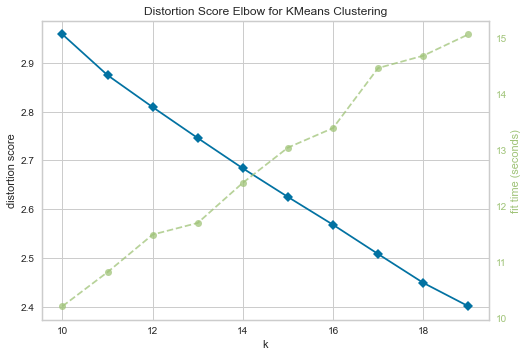

In [44]:
# Calculate elbow point for distortion score for values in test_k range
elbow1 = KElbowVisualizer(kmeans_general,k=test_k)
elbow1.fit(hotel_grouped_clustering)
elbow1.show()

In [45]:
print(f'The distortion score elbow is {elbow1.elbow_value_}.')

The distortion score elbow is None.


We do not see an obvious distortion score elbow point. Let's move on to silhouette score.

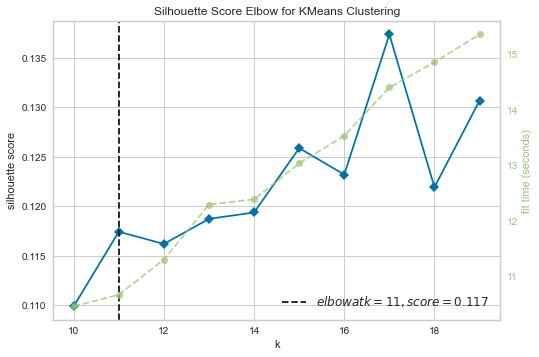

In [46]:
# Calculate elbow point for silhouette score for values in test_k range
elbow2 = KElbowVisualizer(kmeans_general,k=test_k,metric='silhouette')
elbow2.fit(hotel_grouped_clustering)
elbow2.show()

In [47]:
print(f'The best silhouette score is {elbow2.elbow_value_}')

The best silhouette score is 11


We will move forward with 11 clusters based on the silhouette score elbow.
### 5.3 Apply k-means clustering <a name="KMeans"></a>

In [48]:
# Set number of clusters we'd like
kclusters = 11
kmeans_general.n_clusters = kclusters

# Run k-means clustering
kmeans = kmeans_general.fit(hotel_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_

array([10,  4,  4,  2,  0, 10,  4,  3,  4,  2, 10,  5,  5,  4,  5,  6,  7,
        2,  4,  3,  4,  0,  3,  2,  5, 10,  3,  5,  5,  1,  3,  0,  6,  2,
        3,  4,  1,  9,  3,  0, 10,  1,  0,  4, 10,  5,  1,  6,  0,  4, 10,
        4,  4,  1,  5,  5,  5,  9,  4, 10,  2, 10,  3,  3,  2,  3,  4,  4,
       10,  5,  1,  0,  9,  1, 10,  5,  1,  7,  5,  5,  5,  1,  0,  7,  5,
       10,  0,  0,  5,  4,  4, 10,  0,  2,  1,  1,  5,  0, 10,  2,  2,  2,
        5,  4,  2,  1,  1,  0,  0,  7,  4,  0,  3,  7,  5,  4,  5,  5,  0,
       10,  2,  5,  9,  0, 10,  1,  5,  7,  7,  0,  4,  0,  8,  4,  2,  5,
        4,  5,  0,  3,  4,  5,  0,  1,  3,  2,  4,  1,  1,  1, 10,  0,  3,
        2,  2,  3,  0,  7,  7,  1,  9,  0,  5,  1,  7,  2,  5,  9,  5,  2,
        0,  5,  5,  7,  6,  0,  9,  4,  4,  1, 10,  5,  1, 10,  0,  4,  3,
        9,  0,  2,  3,  1,  3, 10,  2, 10,  3,  3, 10, 10,  7,  1,  4,  3,
       10,  2,  2, 10, 10,  9,  4,  2,  0,  5,  5,  2, 10, 10,  6,  4,  9,
        1,  4,  5,  6,  9

In [49]:
# Add clustering labels
hotel_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [82]:
# Number of hotels in each cluster
hotel_venues_sorted.groupby('Cluster Labels').count().reset_index()[['Cluster Labels','Hotel Name']].rename(columns={'Cluster Labels':'Cluster','Hotel Name':'Hotel Count'})

,Cluster,Hotel Count
0,0,31
1,1,27
2,2,27
3,3,25
4,4,36
5,5,36
6,6,6
7,7,15
8,8,1
9,9,11


In [51]:
#hotel_venues_sorted['Cluster Labels'] = kmeans.labels_
hotel_merged = df[['name','latitude','longitude']].rename(columns={'name':'Hotel Name'})
hotel_merged.head()

,Hotel Name,latitude,longitude
0,Hôtel Le Notre-Dame,48.853040,2.346504
1,Hôtel Les Rives de Notre-Dame,48.853252,2.345773
2,Hôtel Henri IV Rive Gauche,48.851885,2.346291
3,Hôtel du Mont-Blanc (Hôtel du Mont Blanc),48.853212,2.345074
4,Hôtel Europe Saint Séverin,48.852726,2.344264


In [52]:
# Merge to add latitude/longitude for each neighborhood
hotel_merged = hotel_merged.join(hotel_venues_sorted.set_index('Hotel Name'), on='Hotel Name')

In [53]:
hotel_merged[['Hotel Name','Cluster Labels']].head()

,Hotel Name,Cluster Labels
0,Hôtel Le Notre-Dame,0
1,Hôtel Les Rives de Notre-Dame,0
2,Hôtel Henri IV Rive Gauche,0
3,Hôtel du Mont-Blanc (Hôtel du Mont Blanc),0
4,Hôtel Europe Saint Séverin,0


In [58]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='CartoDB positron')

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hotel_merged['latitude'], hotel_merged['longitude'], hotel_merged['Hotel Name'], hotel_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [55]:
# Percent breakdown of venues by cluster
cluster_venues = hotel_grouped.join(hotel_merged[['Hotel Name','Cluster Labels']].set_index('Hotel Name'),on='Hotel Name').drop('Hotel Name', axis=1).groupby('Cluster Labels').sum().reset_index()

# move cluster column to the first column
#fixed_columns = [cluster_venues.columns[-1]] + list(cluster_venues.columns[:-1])
#cluster_venues = cluster_venues[fixed_columns]
cluster_venues

,Cluster Labels,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Ch'ti Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Laser Tag,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Store,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Portuguese Restaurant,Provençal Restaurant,Pub,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Resort,Restaurant,Road,Rock Club,Romanian Restaurant,Roof Deck,Rugby Stadium,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shandong Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South A

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cluster_top_venues = pd.DataFrame(columns=columns)
cluster_top_venues['Cluster Labels'] = cluster_venues['Cluster Labels']

for ind in np.arange(cluster_venues.shape[0]):
    cluster_top_venues.iloc[ind, 1:] = return_most_common_venues(cluster_venues.iloc[ind, :], num_top_venues)

cluster_top_venues.T

,0,1,2,3,4,5,6,7,8,9,10
Cluster Labels,0,1,2,3,4,5,6,7,8,9,10
1st Most Common Venue,French Restaurant,French Restaurant,French Restaurant,Hotel,French Restaurant,French Restaurant,Hotel,Hotel,Tennis Court,Hotel,French Restaurant
2nd Most Common Venue,Hotel,Hotel,Hotel,French Restaurant,Hotel,Hotel,French Restaurant,French Restaurant,French Restaurant,Boutique,Bar
3rd Most Common Venue,Plaza,Italian Restaurant,Bar,Bar,Italian Restaurant,Italian Restaurant,Sandwich Place,Japanese Restaurant,Plaza,French Restaurant,Hotel
4th Most Common Venue,Bookstore,Boutique,Italian Restaurant,Italian Restaurant,Bakery,Coffee Shop,Coffee Shop,Boutique,Soccer Stadium,Women's Store,Bistro
5th Most Common Venue,Italian Restaurant,Clothing Store,Bakery,Café,Japanese Restaurant,Bakery,Bakery,Plaza,Sporting Goods Shop,Gourmet Shop,Wine Bar
6th Most Common Venue,Indie Movie Theater,Steakhouse,Bistro,Supermarket,Bistro,Plaza,Nightclub,Jewelry Store,Garden,Clothing Store,Cocktail Bar
7th Most Common Venue,Pub,Café,Japanese Restaurant,Bakery,Plaza,Café,Pizza Place,Chocolate Shop,Italian Restaurant,Department Store,Coffee Shop
8th Most Common Venue,Coffee Shop,Japanese Restaurant,Café,Bistro,Pizza Place,Clothing Store,Cocktail Bar,Bookstore,Supermarket,Sandwich Place,Pizza Place
9th Most Common Venue,Café,Pastry Shop,Pizza Place,Japanese Restaurant,Coffee Shop,Japanese Restaurant,Convenience Store,Clothing Store,Lounge,Bar,Italian Restaurant


Now we have 11 clusters each with their own unique traits.  

For example:
1. Cluster 2 has a high concentration of food of various cuisines.
1. Cluster 8 has plenty of shopping venues, such as boutiques.
1. Cluster 10 has nightlife, with a good deal of bars.

### 5.4 Cluster selection <a name="ClusterSelection"></a>

Personally, I am interested in Cluster 1 which is nearby coffee shops, cafes, pubs and indie movie theaters.

In [83]:
# Initialize selected cluster
fav_cluster = 0

# Display hotels in selected cluster
hotel_merged[hotel_merged['Cluster Labels']==fav_cluster]['Hotel Name']

0                            Hôtel Le Notre-Dame
1                  Hôtel Les Rives de Notre-Dame
2                     Hôtel Henri IV Rive Gauche
3      Hôtel du Mont-Blanc (Hôtel du Mont Blanc)
4                     Hôtel Europe Saint Séverin
5                       Hôtel Parc Saint-Séverin
6                       Hôtel Royal Saint-Michel
8                                 Hôtel Marignan
10                          Hôtel Cluny Square  
11                Holiday Inn Paris - Notre Dame
12                           Les Bulles de Paris
13                                  Hotel Le Lys
15       Petit Belloy St Germain by HappyCulture
17               Hôtel Mercure Paris La Sorbonne
18                          Hôtel Le Lapin Blanc
22                              Hôtel d'Aubusson
23                                  Select Hôtel
24                     Hôtel Dauphine St Germain
26                         Hôtel Design Sorbonne
28                               Hotel Excelsior
29                  

### 5.5 Ranking hotels <a name="Ranking"></a>
Hotels need to be ranked in order to find the best hotel within a cluster.

We have the rating and rating counts for both Foursquare and Yelp, which means we can form a combined rating using a weighted average.

Before we get there, we need to inspect these data.

In [61]:
df.head()

,id,name,latitude,longitude,formattedAddress,city,state,cc,rating,ratingSignals,address,formattedPhone,url,yelp.id,yelp.name,yelp.price,yelp.rating,yelp.review_count,yelp.is_claimed
0,4adcda02f964a520953121e3,Hôtel Le Notre-Dame,48.853040,2.346504,"[1 quai Saint-Michel, 75005 Paris, France]",Paris,Île-de-France,FR,6.9,45.0,1 quai Saint-Michel,+33 1 43 54 20 43,http://www.hotelnotredameparis.com,2i5m01j1Sbq9SW8mxN3lVQ,Hôtel Notre-Dame,2,4.0,14.0,False
1,4adcd9fff964a520af3021e3,Hôtel Les Rives de Notre-Dame,48.853252,2.345773,"[15 quai St Michel, 75005 Paris, France]",Paris,Île-de-France,FR,7.3,8.0,15 quai St Michel,+33 1 43 54 81 16,http://www.rivesdenotredame.com,8jT-Pc7mpVaiK6Cpt5LDtg,Hôtel les Rives de Notre-Dame,2,4.0,3.0,True
2,4cf12e897bf3b60c5d115e7f,Hôtel Henri IV Rive Gauche,48.851885,2.346291,"[11 rue Saint-Jacques (Rue Galande), 75005 Par...",Paris,Île-de-France,FR,6.6,16.0,11 rue Saint-Jacques,+33 1 46 33 20 20,https://henri-paris-hotel.com/fr/,v30EAiKlkqlM6JEZziJC_g,Hotel Henri IV Rive Gauche,2,5.0,8.0,False
3,4ff75c93e4b024f55a0166a4,Hôtel du Mont-Blanc (Hôtel du Mont Blanc),48.853212,2.345074,"[28 rue de la Huchette, 75005 Paris, France]",Paris,Île-de-France,FR,5.4,11.0,28 rue de la Huchette,+33 1 43 54 49 44,http://www.montblancparis.com,e_3SDjYJH9d1AhmJ4Klsug,Hôtel du Mont Blanc,1,3.0,5.0,False
4,4adcda04f964a520183221e3,Hôtel Europe Saint Séverin,48.852726,2.344264,"[40 rue Saint-Séverin, 75005 Paris, France]",Paris,Île-de-France,FR,7.1,43.0,40 rue Saint-Séverin,+33 1 46 34 05 70,https://www.hoteleurope.net,YXWSIEEF5zKKJHpzDWayZw,Hôtel Europe Saint Séverin,2,3.0,14.0,True


In [62]:
# Trim down to fields we need
hotel_picker = df.rename(columns={'name':'Hotel Name'}).join(hotel_merged.set_index('Hotel Name')['Cluster Labels'], on='Hotel Name')

hotel_picker = hotel_picker[['Cluster Labels','Hotel Name','address','url','yelp.price','rating','ratingSignals','yelp.rating','yelp.review_count']].rename(columns={'rating':'foursquare.rating','ratingSignals':'foursquare.ratingCount','yelp.review_count':'yelp.reviewCount'})
hotel_picker.head()

,Cluster Labels,Hotel Name,address,url,yelp.price,foursquare.rating,foursquare.ratingCount,yelp.rating,yelp.reviewCount
0,0,Hôtel Le Notre-Dame,1 quai Saint-Michel,http://www.hotelnotredameparis.com,2,6.9,45.0,4.0,14.0
1,0,Hôtel Les Rives de Notre-Dame,15 quai St Michel,http://www.rivesdenotredame.com,2,7.3,8.0,4.0,3.0
2,0,Hôtel Henri IV Rive Gauche,11 rue Saint-Jacques,https://henri-paris-hotel.com/fr/,2,6.6,16.0,5.0,8.0
3,0,Hôtel du Mont-Blanc (Hôtel du Mont Blanc),28 rue de la Huchette,http://www.montblancparis.com,1,5.4,11.0,3.0,5.0
4,0,Hôtel Europe Saint Séverin,40 rue Saint-Séverin,https://www.hoteleurope.net,2,7.1,43.0,3.0,14.0


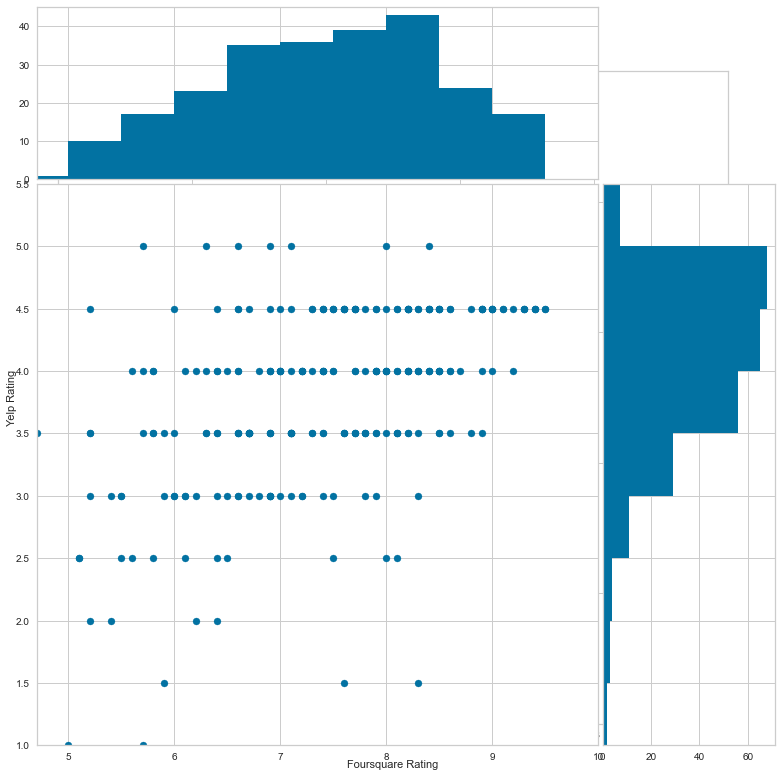

In [63]:
# Pull values for Foursquare and Yelp ratings to input into graph
x = hotel_picker['foursquare.rating'].values
y = hotel_picker['yelp.rating'].values

# Definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# Start with a rectangular Figure
plt.figure(figsize=(12, 12))
plt.xlabel('Foursquare Rating',labelpad = 20)
plt.ylabel('Yelp Rating',labelpad = 20)

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# The scatter plot:
ax_scatter.scatter(x, y)

# Initialize limits
binwidth = 0.5
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((x.min(), x.max()+0.5))
ax_scatter.set_ylim((y.min(), y.max()+0.5))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

The graph shows that the ratings distribution differs between Foursquare and Yelp ratings, which means a weighted average won't do us good in this state.

To circumvent this issue, we will use a quantile transformer to normalize the data into a uniform distribution. That way, our combined average will be clean.

In [64]:
# Initialize and run quantile transformer
qt = QuantileTransformer(n_quantiles=100)
qt_fit = qt.fit_transform(hotel_picker[['foursquare.rating','yelp.rating']])

In [65]:
# Bring transformed ratings into hotel_picker dataframe
hotel_picker = hotel_picker.join(pd.DataFrame(qt_fit)).rename(columns={0:'foursquare.rating.fit',1:'yelp.rating.fit'})
hotel_picker.head()

,Cluster Labels,Hotel Name,address,url,yelp.price,foursquare.rating,foursquare.ratingCount,yelp.rating,yelp.reviewCount,foursquare.rating.fit,yelp.rating.fit
0,0,Hôtel Le Notre-Dame,1 quai Saint-Michel,http://www.hotelnotredameparis.com,2,6.9,45.0,4.0,14.0,0.328283,0.560606
1,0,Hôtel Les Rives de Notre-Dame,15 quai St Michel,http://www.rivesdenotredame.com,2,7.3,8.0,4.0,3.0,0.454545,0.560606
2,0,Hôtel Henri IV Rive Gauche,11 rue Saint-Jacques,https://henri-paris-hotel.com/fr/,2,6.6,16.0,5.0,8.0,0.237374,1.000000
3,0,Hôtel du Mont-Blanc (Hôtel du Mont Blanc),28 rue de la Huchette,http://www.montblancparis.com,1,5.4,11.0,3.0,5.0,0.040404,0.141414
4,0,Hôtel Europe Saint Séverin,40 rue Saint-Séverin,https://www.hoteleurope.net,2,7.1,43.0,3.0,14.0,0.393939,0.141414


In [66]:
# Calculate combined rating
for row in list(hotel_picker.index):
    temp = (hotel_picker.at[row,'foursquare.rating.fit'] * hotel_picker.at[row,'foursquare.ratingCount']) + (hotel_picker.at[row,'yelp.rating.fit'] * hotel_picker.at[row,'yelp.reviewCount'])
    hotel_picker.at[row,'combined.rating'] = temp / (hotel_picker.at[row,'foursquare.ratingCount'] + hotel_picker.at[row,'yelp.reviewCount'])
hotel_picker.head()

,Cluster Labels,Hotel Name,address,url,yelp.price,foursquare.rating,foursquare.ratingCount,yelp.rating,yelp.reviewCount,foursquare.rating.fit,yelp.rating.fit,combined.rating
0,0,Hôtel Le Notre-Dame,1 quai Saint-Michel,http://www.hotelnotredameparis.com,2,6.9,45.0,4.0,14.0,0.328283,0.560606,0.383410
1,0,Hôtel Les Rives de Notre-Dame,15 quai St Michel,http://www.rivesdenotredame.com,2,7.3,8.0,4.0,3.0,0.454545,0.560606,0.483471
2,0,Hôtel Henri IV Rive Gauche,11 rue Saint-Jacques,https://henri-paris-hotel.com/fr/,2,6.6,16.0,5.0,8.0,0.237374,1.000000,0.491582
3,0,Hôtel du Mont-Blanc (Hôtel du Mont Blanc),28 rue de la Huchette,http://www.montblancparis.com,1,5.4,11.0,3.0,5.0,0.040404,0.141414,0.071970
4,0,Hôtel Europe Saint Séverin,40 rue Saint-Séverin,https://www.hoteleurope.net,2,7.1,43.0,3.0,14.0,0.393939,0.141414,0.331916


In [93]:
# Sort by rating (descending)
hotel_picker = hotel_picker.sort_values('combined.rating',ascending=False)
hotel_picker.drop(columns=['address','url','yelp.price']).head(5)

,Cluster Labels,Hotel Name,foursquare.rating,foursquare.ratingCount,yelp.rating,yelp.reviewCount,foursquare.rating.fit,yelp.rating.fit,combined.rating
195,1,Hôtel Four Seasons George V,9.5,913.0,4.5,104.0,1.000000,0.833333,0.982956
130,9,Hôtel de Crillon,9.5,104.0,4.5,12.0,1.000000,0.833333,0.982759
84,10,The Hoxton Paris,9.4,224.0,4.5,14.0,0.989899,0.833333,0.980689
217,1,The Peninsula Paris,9.4,482.0,4.5,41.0,0.989899,0.833333,0.977625
176,1,Hôtel Plaza Athénée,9.4,500.0,4.5,43.0,0.989899,0.833333,0.977501


In [ ]:
hotel_picker[['Hotel Name','Cluster Labels','foursquare.rating','']]

## 6. Results <a name="Results"></a>
I am interested in hotels in cluster 0, specifically with a price point of '2' (originally '€€') or lower.

In [68]:
# Make url clickable
def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

In [84]:
# Establish max price and number of hotels to return
max_price = 2
hotel_count = 3
recommendation = hotel_picker[(hotel_picker['Cluster Labels'] == fav_cluster) & (hotel_picker['yelp.price'] <= max_price)].head(hotel_count)

In [85]:
# Output top hotels
print('**HOTEL RECOMMENDATIONS**')
recommendation[['Hotel Name','address','url','combined.rating']].style.format({'url': make_clickable})

**HOTEL RECOMMENDATIONS**


,Hotel Name,address,url,combined.rating
24,Hôtel Dauphine St Germain,36 rue Dauphine,http://hotel@dauphine-st-germain.com,0.732917
36,Hotel Odéon Saint Germain,13 rue Saint-Sulpice,http://www.paris-hotel-odeon.com,0.641274
38,Artus Hotel,34 Rue de Buci,http://www.hotelsmauricehurand.com,0.619895


In [71]:
df1 = df[df['name'].isin(recommendation['Hotel Name'])]
df1

,id,name,latitude,longitude,formattedAddress,city,state,cc,rating,ratingSignals,address,formattedPhone,url,yelp.id,yelp.name,yelp.price,yelp.rating,yelp.review_count,yelp.is_claimed
147,4bc5fd46bf29c9b6350bf92a,Hôtel ibis Styles Paris Bercy,48.838457,2.381096,"[77 Rue De Bercy, 75012 Paris, France]",Paris,Île-de-France,FR,6.6,71.0,77 Rue De Bercy,+33 1 53 46 50 50,https://all.accor.com/hotel/0941/index.en.shtm...,91bGyElFc4bzNMKqnTV7ng,Hôtel Ibis Styles Paris Bercy,2,3.0,10.0,False
148,4b56acdaf964a520421828e3,Hotel Mercure Paris Opéra Garnier,48.874947,2.326028,"[4 Rue De L 'Isly, 75008 Paris, France]",Paris,Île-de-France,FR,6.9,52.0,4 Rue De L 'Isly,+33 1 43 87 30 55,https://all.accor.com/hotel/1913/index.en.shtm...,m5WY_j_tLIpemYQ0KXKlWA,Hôtel Mercure Relais Opéra Garnier,2,4.5,3.0,False
189,4d31af6ec75a6ea8b39706ae,Hôtel Château Frontenac,48.869121,2.302662,"[54 rue Pierre Charron, 75008 Paris, France]",Paris,Île-de-France,FR,8.5,98.0,54 rue Pierre Charron,+33 1 53 23 13 13,http://www.hfrontenac.com,Ogi5gim2PcwztO0GGn5IyQ,Hôtel Château Frontenac,2,4.0,13.0,True


Let's look at hotels on the map!

In [88]:
# Create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=13,tiles='CartoDB positron')

# Create dataframe with recommended hotels
df1 = df[df['name'].isin(recommendation['Hotel Name'])]

# Add markers to map
for lat, lng, hotel in zip(df1['latitude'], df1['longitude'], df1['name']):
    label = hotel
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris